# This is the model to train the final classifier

The data is in the flower_data folder
We manually changed the files to the new flower data in train and test

Only 5 test data for class 1

In [2]:
import json

with open('flower_data/flower_data/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)



In [3]:
import random
import time
import datetime
import math
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models, utils
from torch.utils.data.sampler import SubsetRandomSampler

import PIL
import os

In [4]:
def _init_fn(worker_id):
   pass

In [5]:
SMALL_SIZE = 12
MEDIUM_SIZE = 30
BIGGER_SIZE = 36

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
cwd = os.getcwd()
img_dir = os.path.join(cwd, '102flowers')
class1_dir = os.path.join(cwd, 'class00001images')
data_dir = os.path.join(cwd, 'flower_data', 'flower_data')
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')


class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

# Number of test data

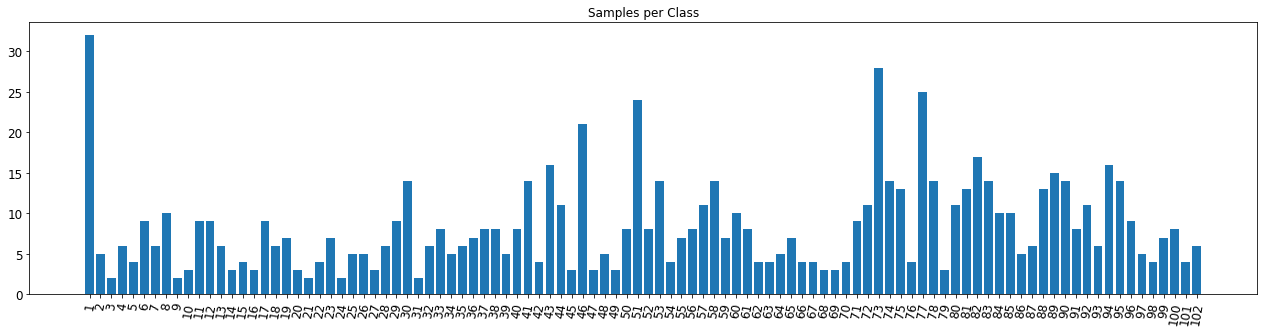

In [6]:
import os

class_sample_counts = {}

for c in range(1, 103):
    l = class_sample_counts.get(c, 0)
    class_sample_counts[c] = l + len(os.listdir(test_dir + '/' + str(c)))

# Plot showing the class imbalance
plt.figure(figsize=(22, 5))    
plt.bar(range(len(class_sample_counts)), list(class_sample_counts.values()), align='center')
plt.xticks(range(len(class_sample_counts)), list(class_sample_counts.keys()))
plt.xticks(rotation=80)
plt.title('Samples per Class')
plt.show()



In [7]:
print(os.listdir('flower_data/flower_data/'))

['cat_to_name.json', 'test', 'train', 'train_1', 'valid']


In [8]:
batch_size = 32

data_transforms = {'train': transforms.Compose([transforms.Resize(256, interpolation=PIL.Image.BILINEAR),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                               ]),
                   'valid': transforms.Compose([transforms.Resize(256, interpolation=PIL.Image.BILINEAR),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                               ])}
                   
image_datasets = {'train': ImageFolderWithPaths(train_dir, transform=data_transforms['train']),
                  'valid': ImageFolderWithPaths(valid_dir, transform=data_transforms['valid'])}

dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=_init_fn),
               'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=_init_fn)}



In [9]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x17d965ebf60>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x17d968f5cc0>}

In [10]:
data_transforms['test'] = transforms.Compose([transforms.Resize(256, interpolation=PIL.Image.BILINEAR),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                               ])
                   
image_datasets['test'] = ImageFolderWithPaths(test_dir, transform=data_transforms['test'])

dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=_init_fn)

In [11]:
import shutil
from random import randrange

In [30]:
cwd = os.getcwd()
img_dir = os.path.join(cwd, '102flowers')
class1_dir = os.path.join(cwd, 'class00001images')

In [31]:
start = 6734
for i in range(0, 400,10):
    imagetochoose = i + randrange(10)
    newlocation = os.path.join(cwd, "flower_data\\flower_data\\train\\1\\image_0" + str(start) + ".jpg")
    start = start + 1
    print(newlocation)
    shutil.move(class1_dir + "\\" + str(imagetochoose) + ".png", newlocation)

C:\jeff\senior\research\text-to-image\flower_data\flower_data\train\1\image_06734.jpg
C:\jeff\senior\research\text-to-image\flower_data\flower_data\train\1\image_06735.jpg
C:\jeff\senior\research\text-to-image\flower_data\flower_data\train\1\image_06736.jpg
C:\jeff\senior\research\text-to-image\flower_data\flower_data\train\1\image_06737.jpg
C:\jeff\senior\research\text-to-image\flower_data\flower_data\train\1\image_06738.jpg
C:\jeff\senior\research\text-to-image\flower_data\flower_data\train\1\image_06739.jpg
C:\jeff\senior\research\text-to-image\flower_data\flower_data\train\1\image_06740.jpg
C:\jeff\senior\research\text-to-image\flower_data\flower_data\train\1\image_06741.jpg
C:\jeff\senior\research\text-to-image\flower_data\flower_data\train\1\image_06742.jpg
C:\jeff\senior\research\text-to-image\flower_data\flower_data\train\1\image_06743.jpg
C:\jeff\senior\research\text-to-image\flower_data\flower_data\train\1\image_06744.jpg
C:\jeff\senior\research\text-to-image\flower_data\flow

In [32]:

dataloader = dataloaders['train']  # Calc mean and std dev on valid dataset.

num_batches = len(dataloader)
num_images = len(dataloader.dataset)

print("num_images =", num_images)

sum_R = 0.0
sum_G = 0.0
sum_B = 0.0

# MEAN 
for batch_idx, (images, labels, paths) in enumerate(dataloader):
    for image in images:
        numpy_image = image.numpy()
        
        sum_R += np.mean(numpy_image[0, :, :])
        sum_G += np.mean(numpy_image[1, :, :])
        sum_B += np.mean(numpy_image[2, :, :])
        
        
mean_R = sum_R / num_images
mean_G = sum_G / num_images
mean_B = sum_B / num_images

print("mean_R =", mean_R)
print("mean_G =", mean_G)
print("mean_B =", mean_B)

variance_sum_R = 0.0
variance_sum_G = 0.0
variance_sum_B = 0.0

# STD
for batch_idx, (images, labels, paths) in enumerate(dataloader):
    for image in images:
        numpy_image = image.numpy()
        
        variance_sum_R += np.mean(np.square(numpy_image[0, :, :] - mean_R))
        variance_sum_G += np.mean(np.square(numpy_image[1, :, :] - mean_G))
        variance_sum_B += np.mean(np.square(numpy_image[2, :, :] - mean_B))


std_R = math.sqrt(variance_sum_R / num_images)
std_G = math.sqrt(variance_sum_G / num_images)
std_B = math.sqrt(variance_sum_B / num_images)

print("std_R =", std_R)
print("std_G =", std_G)
print("std_B =", std_B)

num_images = 6557
mean_R = 0.5185526868486678
mean_G = 0.41059609417162585
mean_B = 0.328709264728159
std_R = 0.29711427467272
std_G = 0.24972758964352312
std_B = 0.2851732337610563


In [33]:
norm_mean = [0.5178361839861569, 0.4106749456881299, 0.32864167836880803]
norm_std = [0.2972239085211309, 0.24976049135203868, 0.28533308036347665]

In [34]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses   
    
    # Counts per label
    for item in images:                                                         
        count[item[1]] += 1                                                     
    
    weight_per_class = [0.] * nclasses
    
    # Total number of images.
    N = float(sum(count))                                                   
    
    # super-sample the smaller classes.
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    
    weight = [0] * len(images)                                              
    
    # Calculate a weight per image.
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    
    return weight

In [35]:
# Using the image datasets and the trainforms, define the dataloaders
batch_size = 32

# Transforms for the training and validation sets
data_transforms = {'train': transforms.Compose([# transforms.Resize(256, interpolation=PIL.Image.BILINEAR),
                                                # transforms.CenterCrop(224),
                                                #===
    
                                                # transforms.RandomResizedCrop(224, 
                                                #                              # scale=(0.75, 1.0), ratio=(1.0, 1.0), 
                                                #                              interpolation=PIL.Image.BILINEAR),
                                                transforms.RandomAffine(45, translate=(0.4, 0.4), scale=(0.75, 1.5), shear=None, resample=PIL.Image.BILINEAR, fillcolor=0),
                                                transforms.Resize(256, interpolation=PIL.Image.BILINEAR),
                                                transforms.CenterCrop(224),
                                                
                                                # transforms.RandomHorizontalFlip(),
                                                # transforms.RandomVerticalFlip(),
                                                # transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.0, hue=0.1),
                                                # transforms.ColorJitter(brightness=0.025, contrast=0.0, saturation=0.0, hue=0.025),
                                                # transforms.RandomGrayscale(p=0.3),
                                                # transforms.RandomRotation(45.0, resample=PIL.Image.BILINEAR),
                                                #===
                                                # transforms.Grayscale(num_output_channels=3),
                                                transforms.ToTensor(),
                                                transforms.Normalize(norm_mean, norm_std),
                                               ]),
                   'valid': transforms.Compose([# transforms.RandomRotation(45, resample=PIL.Image.BILINEAR),
                                                transforms.Resize(256, interpolation=PIL.Image.BILINEAR),
                                                transforms.CenterCrop(224),
                                                # transforms.RandomHorizontalFlip(),
                                                #===
                                                #===
                                                # transforms.Grayscale(num_output_channels=3),
                                                transforms.ToTensor(),
                                                transforms.Normalize(norm_mean, norm_std),
                                               ])}

                   
# Load the datasets with ImageFolder
image_datasets = {'train': ImageFolderWithPaths(train_dir, transform=data_transforms['train']),
                  'valid': ImageFolderWithPaths(valid_dir, transform=data_transforms['valid'])}

weights = make_weights_for_balanced_classes(image_datasets['train'].imgs, len(image_datasets['train'].classes))                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     
                                                                                
  
dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, sampler = sampler, num_workers=0, worker_init_fn=_init_fn),
               'valid': torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=_init_fn)}

In [36]:
data_transforms['test'] = transforms.Compose([# transforms.RandomRotation(45, resample=PIL.Image.BILINEAR),
                                              transforms.Resize(256, interpolation=PIL.Image.BILINEAR),
                                              transforms.CenterCrop(224),
                                              # transforms.RandomHorizontalFlip(),
                                              #===
                                              #===
                                              # transforms.Grayscale(num_output_channels=3),
                                              transforms.ToTensor(),
                                              transforms.Normalize(norm_mean, norm_std),
                                             ])

# Load the datasets with ImageFolder
image_datasets['test'] = ImageFolderWithPaths(test_dir, transform=data_transforms['test'])

dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=True, num_workers=5, worker_init_fn=_init_fn)

In [37]:
def imshow_numpy(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,8))
        
    ax.grid(False)

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array(norm_mean)
    std = np.array(norm_std)
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [38]:
print("len(dataloaders['train'].dataset) =", len(dataloaders['train'].dataset))
print("len(dataloaders['valid'].dataset) =", len(dataloaders['valid'].dataset))

len(dataloaders['train'].dataset) = 6565
len(dataloaders['valid'].dataset) = 818


In [39]:
print("len(dataloaders['test'].dataset) =", len(dataloaders['test'].dataset))

len(dataloaders['test'].dataset) = 846


In [40]:
images, labels, paths = next(iter(dataloaders['train']))
grid_images = utils.make_grid(images)                            
print(paths)
imshow_numpy(grid_images.numpy())


images, labels, paths = next(iter(dataloaders['valid']))
grid_images = utils.make_grid(images)                            
print(paths)
imshow_numpy(grid_images.numpy())

('C:\\jeff\\senior\\research\\text-to-image\\flower_data\\flower_data\\train\\55\\image_04710.jpg', 'C:\\jeff\\senior\\research\\text-to-image\\flower_data\\flower_data\\train\\87\\image_05521.jpg', 'C:\\jeff\\senior\\research\\text-to-image\\flower_data\\flower_data\\train\\28\\image_05260.jpg', 'C:\\jeff\\senior\\research\\text-to-image\\flower_data\\flower_data\\train\\12\\image_04066.jpg', 'C:\\jeff\\senior\\research\\text-to-image\\flower_data\\flower_data\\train\\35\\image_06994.jpg', 'C:\\jeff\\senior\\research\\text-to-image\\flower_data\\flower_data\\train\\101\\image_07945.jpg', 'C:\\jeff\\senior\\research\\text-to-image\\flower_data\\flower_data\\train\\68\\image_05943.jpg', 'C:\\jeff\\senior\\research\\text-to-image\\flower_data\\flower_data\\train\\28\\image_05235.jpg', 'C:\\jeff\\senior\\research\\text-to-image\\flower_data\\flower_data\\train\\32\\image_05624.jpg', 'C:\\jeff\\senior\\research\\text-to-image\\flower_data\\flower_data\\train\\29\\image_04134.jpg', 'C:\\jef

In [16]:
from IPython.display import HTML

In [17]:
def progress_bar(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

  
valid_loss_min_A = np.Inf
valid_acc_max_A = 0

valid_loss_min_B = np.Inf
valid_acc_max_B = 0

train_losses, valid_losses = [], []

In [18]:
class FFClassifier(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = F.log_softmax(x, dim=1)
        return x      
      
      
def save_checkpoint(checkpoint_path, model):
    checkpoint = {
        "class_to_idx": model.class_to_idx,        
        "idx_to_class": model.idx_to_class,        
        "cat_to_name": model.cat_to_name,        
        "state_dict": model.state_dict()
    }
    
    torch.save(checkpoint, checkpoint_path)
    
    
def load_checkpoint(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cpu')

    model = models.resnet152(pretrained=False)
    
    for param in model.parameters():
       param.requires_grad = False

    # Put the classifier on the pretrained network
    model.fc = FFClassifier(2048, 102)

    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint["class_to_idx"]
    model.idx_to_class = checkpoint["idx_to_class"]
    model.cat_to_name = checkpoint["cat_to_name"]
        
    return model

In [44]:
# Load pretrained model.
model = models.resnet152(pretrained=True)
model_requires_grad_params = []

# Freeze parameters so we don't backprop through them
for param in model.parameters():
  if param.requires_grad == True:
      # param.requires_grad = False
      model_requires_grad_params.append(param)

In [45]:
model.fc = FFClassifier(2048, 102)

In [26]:
criterion = nn.NLLLoss()

In [25]:
model.cuda()
    
num_epochs = 20
        
# specify loss function (categorical cross-entropy)
criterion = nn.NLLLoss()

# specify optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

optimizer = optim.Adam(
    [
        {'params': model.conv1.parameters(),  'lr': 0.000001},
        {'params': model.layer1.parameters(), 'lr': 0.000001},
        {'params': model.layer2.parameters(), 'lr': 0.00001},
        {'params': model.layer3.parameters(), 'lr': 0.00001},
        {'params': model.layer4.parameters(), 'lr': 0.0001},
        {'params': model.fc.parameters(),     'lr': 0.001}
    ], lr=0.0, weight_decay=0.001)

# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20, 30, 40], gamma=0.3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=10, verbose=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

for idx, param_group in enumerate(optimizer.param_groups):
    print(idx, param_group['lr'])

RuntimeError: generic_type: cannot initialize type "_CudaDeviceProperties": an object with that name is already defined

In [47]:
def train(n_epochs = 10, manual_lrs = None, run_schedular = True):
    # Need access to some global notebook variables...
    global valid_loss_min_A
    global valid_acc_max_A
    global valid_loss_min_B
    global valid_acc_max_B    
    global train_losses
    global valid_losses

    # Update the param group learning rates if supplied.
    if manual_lrs is not None:
        for idx, param_group in enumerate(optimizer.param_groups):
            param_group['lr'] = manual_lrs[idx]

    for epoch in range(1, n_epochs+1):
        print("Epoch {}".format(epoch))
                
        if run_schedular:
            scheduler.step()

        max_lr = 0.0  # max current lr over param groups.

        for param_group in optimizer.param_groups:
            if param_group['lr'] > max_lr:
              max_lr = param_group['lr']

        print("max_lr = {}".format(max_lr))
        
        # print("LRs", scheduler.get_lr())

        train_loss_sum = 0.0
        valid_loss_sum = 0.0
        train_correct_count = 0.0
        valid_correct_count = 0.0

        
        ##############################################
        # Choose the training and validation datasets.
        
        train_dataloader = dataloaders['train']
        # train_dataloader = super_train_dataloader

        valid_dataloader = dataloaders['valid']
        # valid_dataloader = dataloaders['test']
        ##############################################


        ###################
        # train the model #
        ###################
        print("Training...")

        training_start_time = time.time()
        train_display = display(progress_bar(0, 100), display_id=True)
        model.train()    
        
        num_batches = math.ceil(len(train_dataloader.dataset) / batch_size)

        for batch_idx, (images, labels, paths) in enumerate(train_dataloader):
            # labels are the integer indexes of the class/folder names.

            if cuda_is_available:
                images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(images)  # batch_size x 102
                loss = criterion(outputs, labels)  # Average loss value over batch.
                loss.backward()
                optimizer.step()

            train_loss_sum += loss.item() * images.size(0)  

            _, predicted_labels = torch.max(outputs, -1)
            train_correct_count += (predicted_labels == labels).double().sum().item()   

            progress = (batch_idx+1) * 100.0 / num_batches        
            train_display.update(progress_bar(progress, 100))


        ######################    
        # validate the model #
        ######################
        print("Validating...")

        validation_start_time = time.time()
        valid_display = display(progress_bar(0, 100), display_id=True)
        model.eval()    
        
        num_batches = math.ceil(len(valid_dataloader.dataset) / batch_size)

        for batch_idx, (images, labels, paths) in enumerate(valid_dataloader):
            if cuda_is_available:
                images, labels = images.cuda(), labels.cuda()

            with torch.set_grad_enabled(False):
                outputs = model(images)  # batch_size x 102
                loss = criterion(outputs, labels)  # Average loss value over batch.

            valid_loss_sum += loss.item() * images.size(0)

            _, predicted_labels = torch.max(outputs, -1)
            valid_correct_count += (predicted_labels == labels).double().sum().item()

            progress = (batch_idx+1) * 100.0 / num_batches
            valid_display.update(progress_bar(progress, 100))


        epoch_end_time = time.time()

        ############################
        # calculate average losses #
        ############################
        train_loss = train_loss_sum / len(train_dataloader.dataset)
        valid_loss = valid_loss_sum / len(valid_dataloader.dataset)
        train_acc = train_correct_count / len(train_dataloader.dataset)
        valid_acc = valid_correct_count / len(valid_dataloader.dataset)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)


        #if run_schedular:
        #    scheduler.step(valid_loss)

            
        print('Training Loss={:.6f}  Training Accuracy={:.6f}  Duration={:.2f}'.format(train_loss, 
                                                                                       train_acc, 
                                                                                       validation_start_time - training_start_time))  

        print('Validation Loss={:.6f}  Validation Accuracy={:.6f}  Duration={:.2f}'.format(valid_loss, 
                                                                                           valid_acc, 
                                                                                           epoch_end_time - validation_start_time))


        if (valid_loss < valid_loss_min_A) or ((valid_loss == valid_loss_min_A) and (valid_acc >= valid_acc_max_A)):
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min_A, valid_loss))
            torch.save(model.state_dict(), 'state_dict_best_valid_loss.pt')
            valid_loss_min_A = valid_loss
            valid_acc_max_A = valid_acc

            
        if (valid_acc > valid_acc_max_B) or ((valid_acc == valid_acc_max_B) and (valid_loss <= valid_loss_min_B)):
            print('Validation acc increased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_acc_max_B, valid_acc))
            torch.save(model.state_dict(), 'state_dict_best_valid_acc.pt')
            valid_loss_min_B = valid_loss
            valid_acc_max_B = valid_acc


        print()

In [22]:
cuda_is_available = torch.cuda.is_available()

In [49]:
for param in model_requires_grad_params:
  param.requires_grad = False

# Set smaller learning rates for the earlier layers of the model.
manual_lrs = [0.000001, 
              0.000001, 
              0.00001, 
              0.00001, 
              0.0001, 
              0.001]

train(20, manual_lrs, False)

Epoch 1
max_lr = 0.001
Training...


Validating...


Training Loss=2.581765  Training Accuracy=0.484387  Duration=320.76
Validation Loss=1.063241  Validation Accuracy=0.786064  Duration=32.41
Validation loss decreased (inf --> 1.063241).  Saving model ...
Validation acc increased (0.000000 --> 0.786064).  Saving model ...

Epoch 2
max_lr = 0.001
Training...


Validating...


Training Loss=1.018465  Training Accuracy=0.794669  Duration=318.32
Validation Loss=0.628612  Validation Accuracy=0.855746  Duration=29.02
Validation loss decreased (1.063241 --> 0.628612).  Saving model ...
Validation acc increased (0.786064 --> 0.855746).  Saving model ...

Epoch 3
max_lr = 0.001
Training...


Validating...


Training Loss=0.757337  Training Accuracy=0.830465  Duration=321.32
Validation Loss=0.414580  Validation Accuracy=0.911980  Duration=28.60
Validation loss decreased (0.628612 --> 0.414580).  Saving model ...
Validation acc increased (0.855746 --> 0.911980).  Saving model ...

Epoch 4
max_lr = 0.001
Training...


Validating...


Training Loss=0.615897  Training Accuracy=0.850724  Duration=321.32
Validation Loss=0.419523  Validation Accuracy=0.883863  Duration=28.86

Epoch 5
max_lr = 0.001
Training...


Validating...


Training Loss=0.527259  Training Accuracy=0.877685  Duration=320.58
Validation Loss=0.331020  Validation Accuracy=0.916870  Duration=28.71
Validation loss decreased (0.414580 --> 0.331020).  Saving model ...
Validation acc increased (0.911980 --> 0.916870).  Saving model ...

Epoch 6
max_lr = 0.001
Training...


Validating...


Training Loss=0.513289  Training Accuracy=0.871592  Duration=319.82
Validation Loss=0.341838  Validation Accuracy=0.921760  Duration=28.93
Validation acc increased (0.916870 --> 0.921760).  Saving model ...

Epoch 7
max_lr = 0.001
Training...


Validating...


Training Loss=0.493956  Training Accuracy=0.877380  Duration=324.53
Validation Loss=0.294651  Validation Accuracy=0.930318  Duration=28.86
Validation loss decreased (0.331020 --> 0.294651).  Saving model ...
Validation acc increased (0.921760 --> 0.930318).  Saving model ...

Epoch 8
max_lr = 0.001
Training...


Validating...


Training Loss=0.458716  Training Accuracy=0.883473  Duration=321.44
Validation Loss=0.274666  Validation Accuracy=0.935208  Duration=28.82
Validation loss decreased (0.294651 --> 0.274666).  Saving model ...
Validation acc increased (0.930318 --> 0.935208).  Saving model ...

Epoch 9
max_lr = 0.001
Training...


Validating...


Training Loss=0.431077  Training Accuracy=0.888195  Duration=321.85
Validation Loss=0.254562  Validation Accuracy=0.936430  Duration=28.95
Validation loss decreased (0.274666 --> 0.254562).  Saving model ...
Validation acc increased (0.935208 --> 0.936430).  Saving model ...

Epoch 10
max_lr = 0.001
Training...


Validating...


Training Loss=0.403241  Training Accuracy=0.897944  Duration=339.02
Validation Loss=0.275592  Validation Accuracy=0.930318  Duration=30.35

Epoch 11
max_lr = 0.001
Training...


Validating...


Training Loss=0.423604  Training Accuracy=0.889718  Duration=342.01
Validation Loss=0.257287  Validation Accuracy=0.936430  Duration=29.08

Epoch 12
max_lr = 0.001
Training...


Validating...


Training Loss=0.397387  Training Accuracy=0.896116  Duration=344.29
Validation Loss=0.263608  Validation Accuracy=0.929095  Duration=29.30

Epoch 13
max_lr = 0.001
Training...


Validating...


Training Loss=0.400596  Training Accuracy=0.893069  Duration=338.97
Validation Loss=0.248586  Validation Accuracy=0.936430  Duration=29.29
Validation loss decreased (0.254562 --> 0.248586).  Saving model ...
Validation acc increased (0.936430 --> 0.936430).  Saving model ...

Epoch 14
max_lr = 0.001
Training...


Validating...


Training Loss=0.385870  Training Accuracy=0.899162  Duration=328.73
Validation Loss=0.231623  Validation Accuracy=0.941320  Duration=28.70
Validation loss decreased (0.248586 --> 0.231623).  Saving model ...
Validation acc increased (0.936430 --> 0.941320).  Saving model ...

Epoch 15
max_lr = 0.001
Training...


Validating...


Training Loss=0.408765  Training Accuracy=0.890632  Duration=320.18
Validation Loss=0.299999  Validation Accuracy=0.913203  Duration=28.74

Epoch 16
max_lr = 0.001
Training...


Validating...


Training Loss=0.407498  Training Accuracy=0.886367  Duration=322.27
Validation Loss=0.252000  Validation Accuracy=0.935208  Duration=28.53

Epoch 17
max_lr = 0.001
Training...


Validating...


Training Loss=0.372627  Training Accuracy=0.904494  Duration=319.50
Validation Loss=0.275470  Validation Accuracy=0.927873  Duration=28.72

Epoch 18
max_lr = 0.001
Training...


Validating...


Training Loss=0.368995  Training Accuracy=0.900381  Duration=318.93
Validation Loss=0.267496  Validation Accuracy=0.935208  Duration=28.41

Epoch 19
max_lr = 0.001
Training...


Validating...


Training Loss=0.384730  Training Accuracy=0.901295  Duration=317.75
Validation Loss=0.232595  Validation Accuracy=0.944988  Duration=28.54
Validation acc increased (0.941320 --> 0.944988).  Saving model ...

Epoch 20
max_lr = 0.001
Training...


Validating...


Training Loss=0.339399  Training Accuracy=0.906778  Duration=317.90
Validation Loss=0.217990  Validation Accuracy=0.940098  Duration=28.67
Validation loss decreased (0.231623 --> 0.217990).  Saving model ...



In [19]:
model.load_state_dict(torch.load('state_dict_best_valid_loss.pt'))

KeyboardInterrupt: 

In [51]:


# UN-Freeze the earlier layers of the pre-trained network!
for param in model_requires_grad_params:
  param.requires_grad = True

# Set smaller learning rates for the earlier layers of the model.
manual_lrs = [0.000001, 
              0.000001, 
              0.00001, 
              0.00001, 
              0.0001, 
              0.001]

train(num_epochs, manual_lrs, True)



Epoch 1
max_lr = 0.001
Training...


RuntimeError: cuda runtime error (2) : out of memory at c:\programdata\miniconda3\conda-bld\pytorch_1524543037166\work\aten\src\thc\generic/THCStorage.cu:58

In [52]:
plt.figure(figsize=(20,10))
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [53]:
model.load_state_dict(torch.load('state_dict_best_valid_loss.pt'))

RuntimeError: Error(s) in loading state_dict for ResNet:
	While copying the parameter named "conv1.weight", whose dimensions in the model are torch.Size([64, 3, 7, 7]) and whose dimensions in the checkpoint are torch.Size([64, 3, 7, 7]).

In [28]:
idx_to_class = {v: k for k, v in image_datasets['train'].class_to_idx.items()}

In [58]:


# idx is the same as the label.
# class is the folder name ['1'...'102']

model.class_to_idx = image_datasets['train'].class_to_idx
model.idx_to_class = idx_to_class
model.cat_to_name = cat_to_name

# Save the checkpoint 
save_checkpoint('model_checkpoint.pt', model)

# Also save to gdrive.
ts = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')
checkpointsave = os.path.join(cwd, 'checkpoint', 'model_checkpoint_B_10-29-2019.pt')
save_checkpoint(checkpointsave, model)



In [20]:
model = load_checkpoint('model_checkpoint.pt')

In [15]:
valid_loss_sum = 0.0
valid_correct_count = 0.0

######################    
# validate the model #
######################
validation_start_time = time.time()
print("Validating...")
valid_display = display(progress_bar(0, 100), display_id=True)

model.eval()    

if cuda_is_available:
    model.cuda()

num_batches = math.ceil(len(dataloaders['valid'].dataset) / batch_size)

for batch_idx, (images, labels, paths) in enumerate(dataloaders['valid']):

    if cuda_is_available:
        images, labels = images.cuda(), labels.cuda()

    with torch.set_grad_enabled(False):
        outputs = model(images)  # batch_size x 102
        loss = criterion(outputs, labels)  # Average loss value over batch.

    valid_loss_sum += loss.item() * images.size(0)

    _, predicted_labels = torch.max(outputs, -1)
    valid_correct_count += (predicted_labels == labels).double().sum().item()
        
    for i in range(len(labels.data)):
        if labels[i] != predicted_labels[i]:
            print(paths[i], " truth =", idx_to_class[labels[i].item()]," predicted =", idx_to_class[predicted_labels[i].item()])

    progress = (batch_idx+1) * 100.0 / num_batches
    valid_display.update(progress_bar(progress, 100))


validation_end_time = time.time()

############################
# calculate average losses #
############################
valid_loss = valid_loss_sum / len(dataloaders['valid'].dataset)
valid_acc = valid_correct_count / len(dataloaders['valid'].dataset)

print('Validation Loss={:.6f}  Validation Accuracy={:.6f}  Duration={:.2f}'.format(valid_loss, 
                                                                                   valid_acc, 
                                                                                   validation_end_time - validation_start_time))

Validating...


NameError: name 'progress_bar' is not defined

In [34]:
test_loss_sum = 0.0
test_correct_count = 0.0

##################    
# test the model #\||
##################
testing_start_time = time.time()
print("Testing...")
test_display = display(progress_bar(0, 100), display_id=True)

model.eval()   
cuda_is_available = False
if cuda_is_available:
    model.cuda()

num_batches = math.ceil(len(dataloaders['test'].dataset) / batch_size)
totalclass1 = 0
correctlypredicted1 = 0
totalpredicted1 = 0
for batch_idx, (images, labels, paths) in enumerate(dataloaders['test']):

    if cuda_is_available:
        images, labels = images.cuda(), labels.cuda()

    with torch.set_grad_enabled(False):
        outputs = model(images)  # batch_size x 102
        loss = criterion(outputs, labels)  # Average loss value over batch.

    test_loss_sum += loss.item() * images.size(0)

    _, predicted_labels = torch.max(outputs, -1)
    test_correct_count += (predicted_labels == labels).double().sum().item()

    totalclass1 += len((labels == 1).nonzero())
    for i in (predicted_labels == 1).nonzero():
        index = i.item()
        if labels[index].item() == 1:
            correctlypredicted1 += 1
    
    for i in range(len(labels.data)):
        if labels[i] != predicted_labels[i]:
            print(paths[i], " truth =", idx_to_class[labels[i].item()]," predicted =", idx_to_class[predicted_labels[i].item()])
        if predicted_labels[i].item() == 1:
            totalpredicted1 += 1
        if labels[i].item() == 1:
            totalclass1 += 1
        if labels[i].item() == 1 and predicted_labels[i].item() == 1:
            correctlypredicted1 += 1
    progress = (batch_idx+1) * 100.0 / num_batches
    test_display.update(progress_bar(progress, 100))


testing_end_time = time.time()

############################
# calculate average losses #
############################
test_loss = test_loss_sum / len(dataloaders['test'].dataset)
test_acc = test_correct_count / len(dataloaders['test'].dataset)

print('Testing Loss={:.6f}  Testing Accuracy={:.6f}  Duration={:.2f}'.format(test_loss, 
                                                                             test_acc, 
                                                                             testing_end_time - testing_start_time))

Testing...


C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\101\image_07988.jpg  truth = 101  predicted = 58
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\100\image_07897.jpg  truth = 100  predicted = 41
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\74\image_01276.jpg  truth = 74  predicted = 4
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\25\image_06583.jpg  truth = 25  predicted = 22
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\84\image_02572.jpg  truth = 84  predicted = 65
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\48\image_04667.jpg  truth = 48  predicted = 65
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\1\image_06752.jpg  truth = 1  predicted = 65
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\1\image_06770.jpg  truth = 1  predicted = 86
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\51\image_03989.jpg  tr

C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\84\image_02557.jpg  truth = 84  predicted = 37
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\83\image_01755.jpg  truth = 83  predicted = 89
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\42\image_05731.jpg  truth = 42  predicted = 37
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\82\image_01609.jpg  truth = 82  predicted = 86
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\53\image_03689.jpg  truth = 53  predicted = 81
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\90\image_04417.jpg  truth = 90  predicted = 68
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\40\image_04586.jpg  truth = 40  predicted = 55
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\6\image_07185.jpg  truth = 6  predicted = 91
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\82\image_01662.jpg  tru

C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\94\image_07415.jpg  truth = 94  predicted = 87
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\12\image_03994.jpg  truth = 12  predicted = 14
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\52\image_04221.jpg  truth = 52  predicted = 65
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\84\image_02583.jpg  truth = 84  predicted = 87
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\85\image_04814.jpg  truth = 85  predicted = 43
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\18\image_04277.jpg  truth = 18  predicted = 91
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\94\image_07436.jpg  truth = 94  predicted = 3
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\1\image_06764.jpg  truth = 1  predicted = 55
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\1\image_06747.jpg  truth

C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\79\image_06708.jpg  truth = 79  predicted = 73
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\51\image_03954.jpg  truth = 51  predicted = 58
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\1\image_06767.jpg  truth = 1  predicted = 51
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\26\image_06497.jpg  truth = 26  predicted = 80
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\82\image_01610.jpg  truth = 82  predicted = 34
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\96\image_07683.jpg  truth = 96  predicted = 97
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\54\image_05440.jpg  truth = 54  predicted = 41
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\46\image_00961.jpg  truth = 46  predicted = 65
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\85\image_04786.jpg  tru

C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\40\image_04587.jpg  truth = 40  predicted = 95
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\46\image_01090.jpg  truth = 46  predicted = 65
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\7\image_07219.jpg  truth = 7  predicted = 32
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\48\image_04665.jpg  truth = 48  predicted = 65
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\92\image_03049.jpg  truth = 92  predicted = 13
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\53\image_03645.jpg  truth = 53  predicted = 65
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\34\image_06961.jpg  truth = 34  predicted = 37
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\60\image_02933.jpg  truth = 60  predicted = 58
C:\jeff\senior\research\text-to-image\flower_data\flower_data\test\1\image_06757.jpg  trut

In [37]:
correctlypredicted1

2

In [38]:
totalclass1

3

# 100% but only 3 cases....

In [45]:
idx_to_class[predicted_labels[0].item()]

'37'

29 incorrect
32 total

In [39]:
totalpredicted1

0

In [ ]:
labels.data

In [ ]:
predicted_labels

In [ ]:
print((labels == 1).nonzero())

In [ ]:
print((predicted_labels == 1).nonzero())

In [ ]:
len((labels == 2).nonzero())

In [ ]:
labels[2].item()